# 1. Generating five images passing five noise vectors/matrices drawn from a normal distribution with mean 5 and variance 1 through the Decoder of your normal Autoencoder.

## Import Necessary Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

## Load and Preprocess the CIFAR-10 Dataset

In [3]:
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print('Shape of flattened training data:', x_train_flat.shape)
print('Shape of flattened test data:', x_test_flat.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Shape of flattened training data: (50000, 3072)
Shape of flattened test data: (10000, 3072)


## Build the Autoencoder Model

In [4]:
LATENT_DIM = 32
INPUT_DIM = 3072

encoder_input = Input(shape=(INPUT_DIM,))
x = Dense(128, activation='relu')(encoder_input)
encoder_output = Dense(LATENT_DIM, activation='relu')(x)
encoder = Model(encoder_input, encoder_output, name='encoder')
print("--- Encoder Summary ---")
encoder.summary()

decoder_input = Input(shape=(LATENT_DIM,))
x = Dense(128, activation='relu')(decoder_input)
decoder_output = Dense(INPUT_DIM, activation='sigmoid')(x)
decoder = Model(decoder_input, decoder_output, name='decoder')
print("\n--- Decoder Summary ---")
decoder.summary()

autoencoder_input = Input(shape=(INPUT_DIM,))
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = Model(autoencoder_input, decoded_img, name='autoencoder')
print("\n--- Full Autoencoder Summary ---")
autoencoder.summary()

--- Encoder Summary ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,472 (1.52 MB)

 Trainable params: 397,472 (1.52 MB)

 Non-trainable params: 0 (0.00 B)


--- Decoder Summary ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3072)           │       396,288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,512 (1.53 MB)

 Trainable params: 400,512 (1.53 MB)

 Non-trainable params: 0 (0.00 B)


--- Full Autoencoder Summary ---


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       397,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 3072)           │       400,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 797,984 (3.04 MB)

 Trainable params: 797,984 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the Autoencoder

In [5]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

print("\n--- Training the Autoencoder ---")
history = autoencoder.fit(
    x_train_flat, x_train_flat,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_flat, x_test_flat)
)


--- Training the Autoencoder ---
Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0498 - val_loss: 0.0293
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0280 - val_loss: 0.0232
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0226 - val_loss: 0.0211
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0212 - val_loss: 0.0209
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0204 - val_loss: 0.0201
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0202 - val_loss: 0.0201
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0202 - val_loss: 0.0200
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0199 - val_loss: 0.0200
Epoch 9/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0196 - val_loss: 0.0199
Epoch 10/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 11/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0194 - val_loss: 0.0193
Epoch 12/20
196/1

## Generate and Display Images from Noise

Shape of generated noise vectors: (5, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


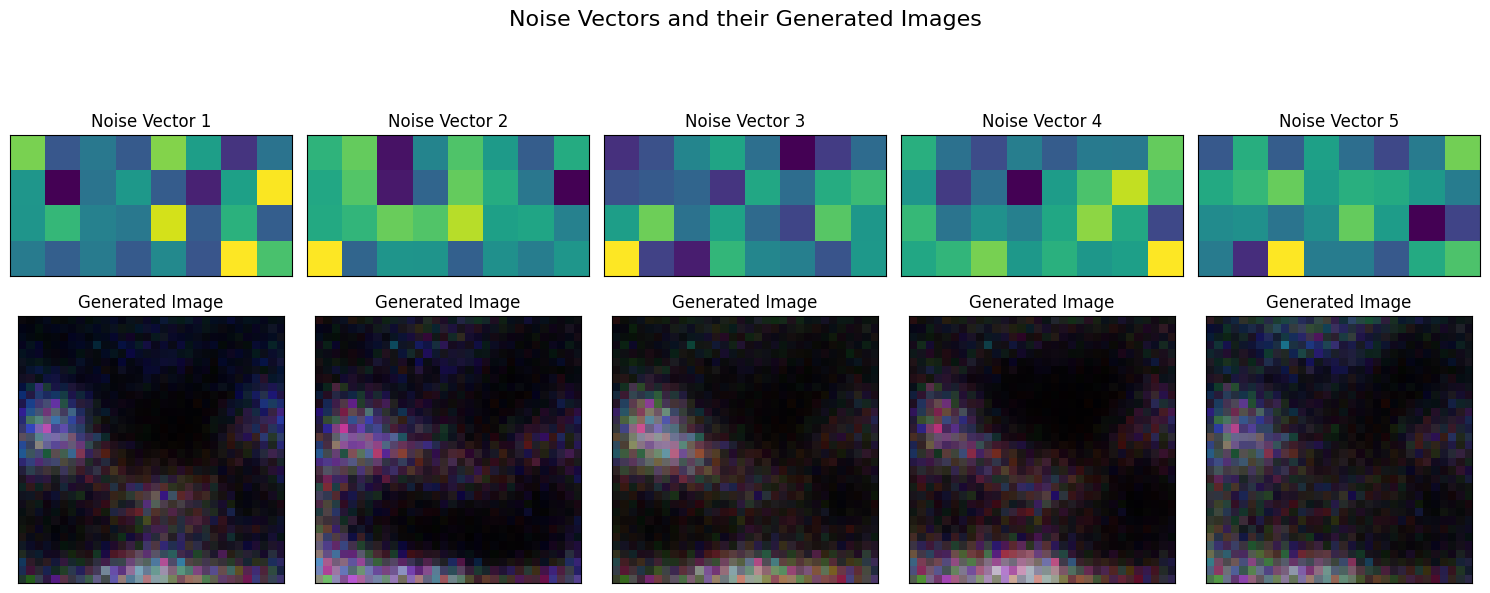

In [6]:
n = 5

noise_mean = 5.0
noise_variance = 1.0
noise_stddev = np.sqrt(noise_variance)

noise_vectors = np.random.normal(loc=noise_mean, scale=noise_stddev, size=(n, LATENT_DIM))

print(f"Shape of generated noise vectors: {noise_vectors.shape}")

generated_images_flat = decoder.predict(noise_vectors)

generated_images = generated_images_flat.reshape(n, 32, 32, 3)

plt.figure(figsize=(15, 6))
plt.suptitle("Noise Vectors and their Generated Images", fontsize=16)

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noise_vectors[i].reshape(4, 8), cmap='viridis')
    plt.title(f"Noise Vector {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generated_images[i], cmap='gray')
    plt.title("Generated Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 2. Generating five images passing five noise vectors/matrices drawn from a normal distribution with mean 5 and variance through the Decoder of your Denoising Autoencoder.

## Load and Preprocess the CIFAR-10 Dataset

In [7]:
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples


## Add Noise to the Dataset

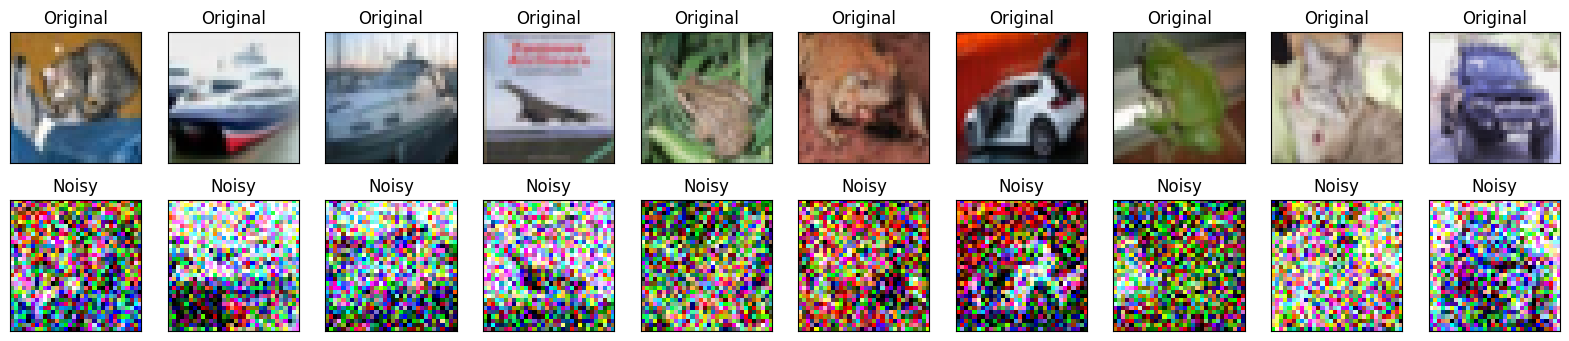

In [8]:
noise_factor = 0.4

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Build the Denoising Autoencoder Model

In [9]:
LATENT_DIM = 32

encoder_input = Input(shape=(32, 32, 3))
x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(encoder_input) # 14x14
x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x) # 7x7
shape_before_flattening = x.shape[1:]
x = Flatten()(x)
encoder_output = Dense(LATENT_DIM, activation='relu')(x)
encoder = Model(encoder_input, encoder_output, name='encoder')
print("--- Encoder Summary ---")
encoder.summary()

decoder_input = Input(shape=(LATENT_DIM,))
x = Dense(np.prod(shape_before_flattening), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x) # 14x14
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2)(x) # 28x28
decoder_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(decoder_input, decoder_output, name='decoder')
print("\n--- Decoder Summary ---")
decoder.summary()

autoencoder_input = Input(shape=(32, 32, 3))
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
denoising_autoencoder = Model(autoencoder_input, decoded_img, name='denoising_autoencoder')
print("\n--- Full Denoising Autoencoder Summary ---")
denoising_autoencoder.summary()

--- Encoder Summary ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        65,568 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,656 (276.00 KB)

 Trainable params: 70,656 (276.00 KB)

 Non-trainable params: 0 (0.00 B)


--- Decoder Summary ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2048)           │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,891 (319.89 KB)

 Trainable params: 81,891 (319.89 KB)

 Non-trainable params: 0 (0.00 B)


--- Full Denoising Autoencoder Summary ---


Model: "denoising_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │        81,891 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,547 (595.89 KB)

 Trainable params: 152,547 (595.89 KB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the Denoising Autoencoder

In [10]:
denoising_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

print("\n--- Training the Denoising Autoencoder ---")
denoising_autoencoder.fit(
    x_train_noisy, x_train,
    epochs=25,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


--- Training the Denoising Autoencoder ---
Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.6299 - val_loss: 0.5940
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5920 - val_loss: 0.5916
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.5894 - val_loss: 0.5900
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5888 - val_loss: 0.5896
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5881 - val_loss: 0.5892
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5881 - val_loss: 0.5887
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5874 - val_loss: 0.5888
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5877 - val_loss: 0.5885
Epoch 9/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5874 - val_loss: 0.5889
Epoch 10/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5873 - val_loss: 0.5882
Epoch 11/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5870 - val_loss: 0.5880
Epoch 1

## Generate and Display Images from Noise

Shape of generated noise vectors: (5, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


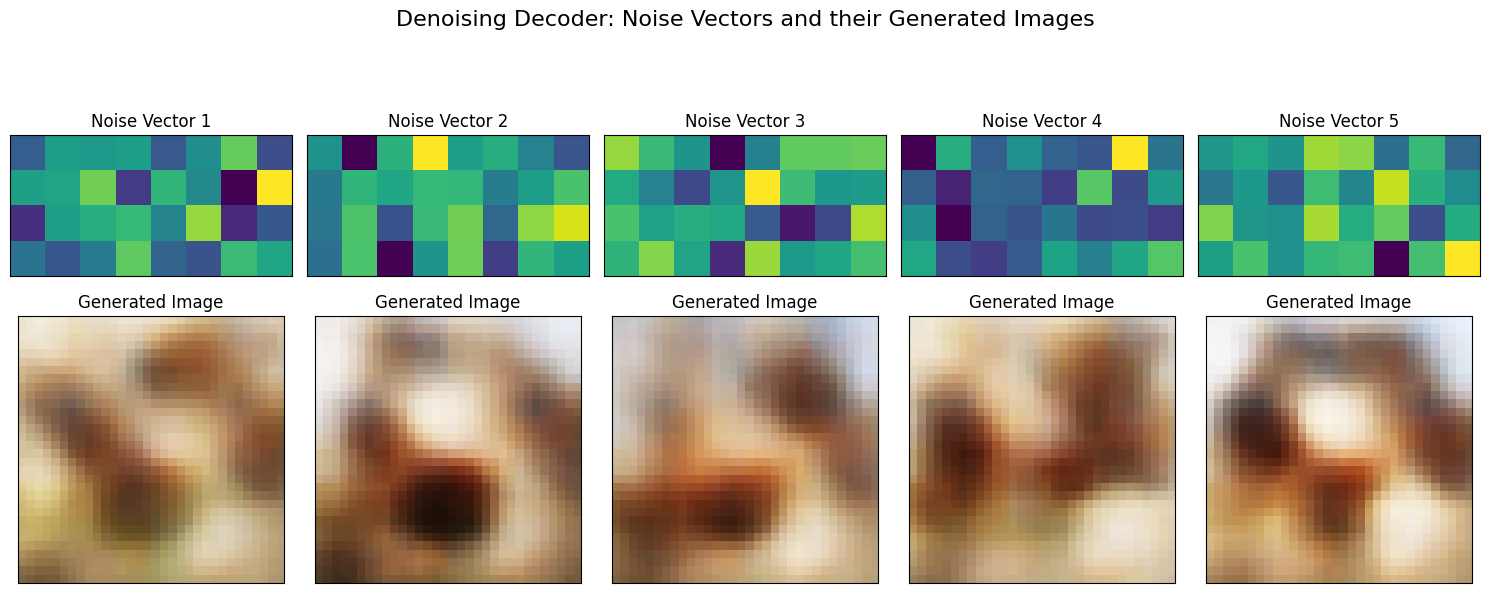

In [11]:
n = 5

noise_mean = 5.0
noise_variance = 1.0
noise_stddev = np.sqrt(noise_variance)

noise_vectors = np.random.normal(loc=noise_mean, scale=noise_stddev, size=(n, LATENT_DIM))

print(f"Shape of generated noise vectors: {noise_vectors.shape}")

generated_images = decoder.predict(noise_vectors)

plt.figure(figsize=(15, 6))
plt.suptitle("Denoising Decoder: Noise Vectors and their Generated Images", fontsize=16)

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noise_vectors[i].reshape(4, 8), cmap='viridis')
    plt.title(f"Noise Vector {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generated_images[i].reshape(32, 32, 3), cmap='gray')
    plt.title("Generated Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 3. Training and evaluating a Variational Autoencoder

## Load and Preprocess the CIFAR-10 Dataset



In [12]:
(x_train, _), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


## Building the VAE Model Components

In [13]:
LATENT_DIM = 2
IMAGE_SHAPE = (32, 32, 3)

# --- Encoder ---
encoder_inputs = Input(shape=IMAGE_SHAPE)
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)  # 16x16x32
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)               # 8x8x64
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

z_mean = Dense(LATENT_DIM, name='z_mean')(x)
z_log_var = Dense(LATENT_DIM, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(LATENT_DIM,), name='z')([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
print("--- Encoder Summary ---")
encoder.summary()

# --- Decoder ---
decoder_inputs = Input(shape=(LATENT_DIM,))
x = Dense(8 * 8 * 64, activation='relu')(decoder_inputs)
x = Reshape((8, 8, 64))(x)
x = Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)  # 16x16x64
x = Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)  # 32x32x32
decoder_outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)  # 32x32x3

decoder = Model(decoder_inputs, decoder_outputs, name='decoder')
print("\n--- Decoder Summary ---")
decoder.summary()

--- Encoder Summary ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │        896 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4096)      │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    524,416 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 544,324 (2.08 MB)

 Trainable params: 544,324 (2.08 MB)

 Non-trainable params: 0 (0.00 B)


--- Decoder Summary ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,547 (267.76 KB)

 Trainable params: 68,547 (267.76 KB)

 Non-trainable params: 0 (0.00 B)

## Defining the Full VAE Model with Custom Loss

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def _calculate_loss(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss
        return total_loss, reconstruction_loss, kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            total_loss, reconstruction_loss, kl_loss = self._calculate_loss(data)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        total_loss, reconstruction_loss, kl_loss = self._calculate_loss(data)

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

print("VAE model class defined with call() and test_step().")

VAE model class defined with call() and test_step().


## Instantiate, Compile, and Train the VAE

In [15]:
vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam())

print("\n--- Training the VAE ---")
history = vae.fit(x_train, epochs=20, batch_size=128, validation_data=(x_test, None))


--- Training the VAE ---
Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - kl_loss: 2.2382 - reconstruction_loss: 684.1934 - total_loss: 686.4316 - val_kl_loss: 4.2213 - val_reconstruction_loss: 653.0803 - val_total_loss: 657.3013
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - kl_loss: 4.1702 - reconstruction_loss: 651.4645 - total_loss: 655.6345 - val_kl_loss: 4.0645 - val_reconstruction_loss: 652.5643 - val_total_loss: 656.6288
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 4.0392 - reconstruction_loss: 651.0930 - total_loss: 655.1321 - val_kl_loss: 4.1493 - val_reconstruction_loss: 652.1163 - val_total_loss: 656.2655
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 4.0292 - reconstruction_loss: 651.0839 - total_loss: 655.1130 - val_kl_loss: 3.8391 - val_reconstruction_loss: 652.3627 - val_total_loss: 656.2019
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - kl_loss: 4.0052 - reconstruction_loss: 651.2299 - total_loss: 655.2349 - val_k

## Evaluate the Trained VAE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


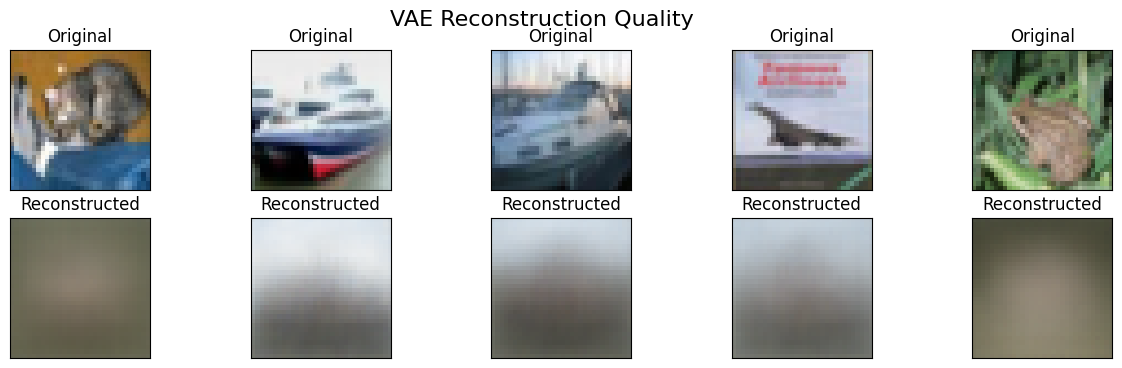

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


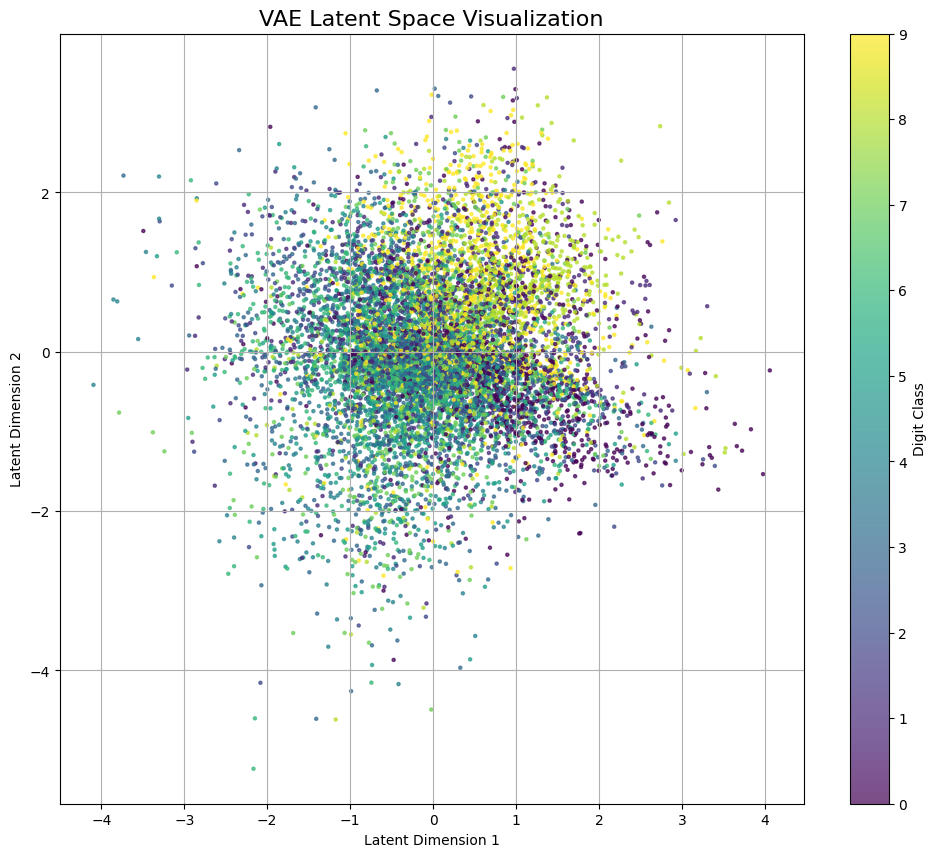

In [28]:
n = 5
sample_images = x_test[:n]

_, _, z_samples = vae.encoder.predict(sample_images)
reconstructed_images = vae.decoder.predict(z_samples)

plt.figure(figsize=(15, 4))
plt.suptitle("VAE Reconstruction Quality", fontsize=16)
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sample_images[i].reshape(32, 32,3), cmap= None)
    ax.set_title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(32, 32, 3), cmap=None)
    ax.set_title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

z_mean, _, _ = vae.encoder.predict(x_test, batch_size=128)

plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', s=5, alpha=0.7)
plt.colorbar(label='Digit Class')
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("VAE Latent Space Visualization", fontsize=16)
plt.grid(True)
plt.show()

## Generated Image from Random Noise with Mean 5 and Variance 1

Shape of generated noise vectors: (5, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


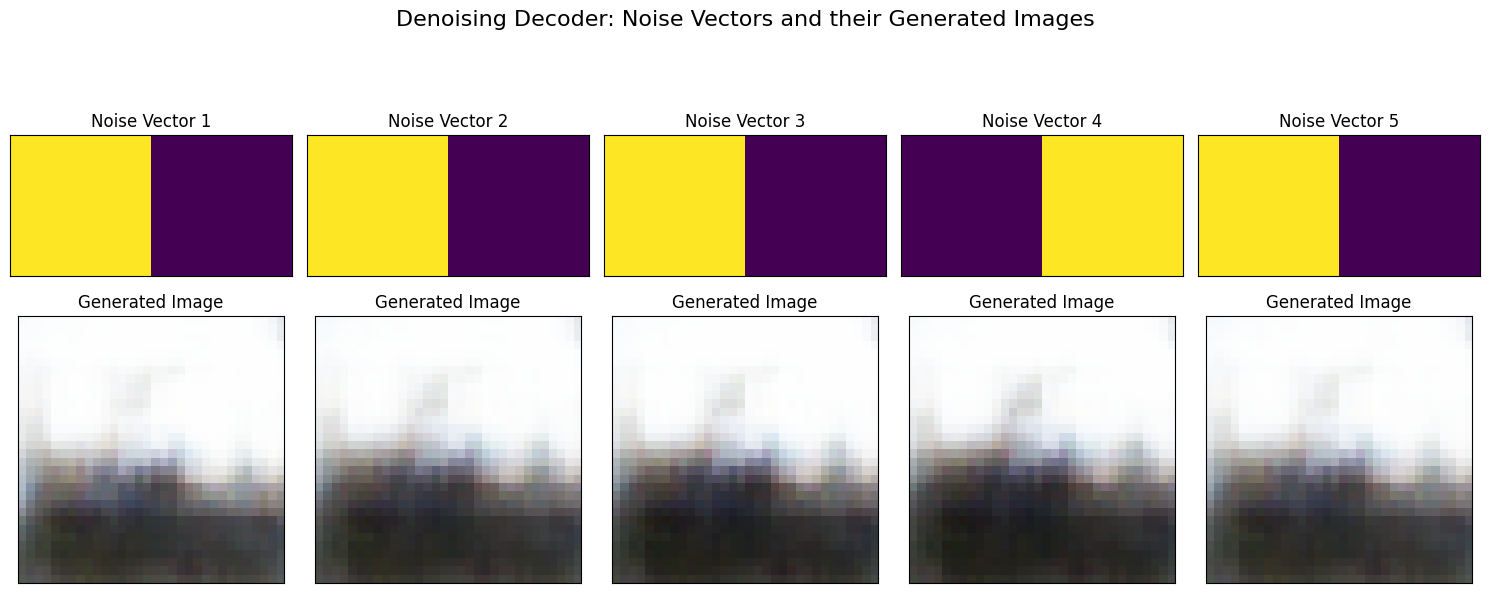

In [27]:
n = 5

noise_mean = 5.0
noise_variance = 1.0
noise_stddev = np.sqrt(noise_variance)

noise_vectors = np.random.normal(loc=noise_mean, scale=noise_stddev, size=(n, LATENT_DIM))

print(f"Shape of generated noise vectors: {noise_vectors.shape}")

generated_images = decoder.predict(noise_vectors)

plt.figure(figsize=(15, 6))
plt.suptitle("Denoising Decoder: Noise Vectors and their Generated Images", fontsize=16)

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noise_vectors[i].reshape(1, 2), cmap='viridis')
    plt.title(f"Noise Vector {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generated_images[i].reshape(32, 32,3), cmap= None)
    plt.title("Generated Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Calculated Cluster Centers in Latent Space:
  Digit 0: [0.75, -0.12]
  Digit 1: [-0.02, 0.28]
  Digit 2: [-0.06, -0.10]
  Digit 3: [-0.22, -0.26]
  Digit 4: [-0.37, -0.20]
  Digit 5: [-0.21, -0.40]
  Digit 6: [-0.44, -0.06]
  Digit 7: [-0.01, -0.04]
  Digit 8: [0.52, 0.42]
  Digit 9: [0.37, 0.66]

Shape of generated targeted vectors: (5, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


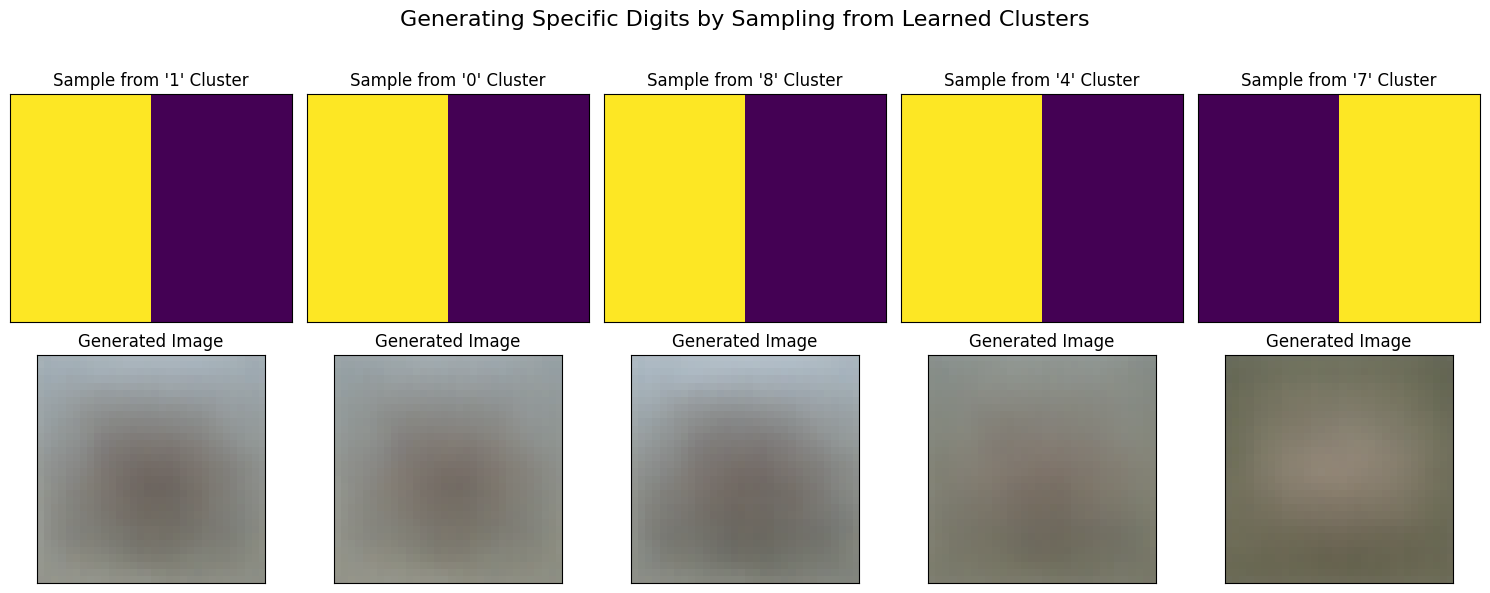

In [26]:
z_mean, _, _ = vae.encoder.predict(x_test, batch_size=128)
y_test = y_test.flatten()
cluster_centers = {}
for digit in range(10):
    z_mean_digit = z_mean[y_test == digit]
    center = np.mean(z_mean_digit, axis=0)
    cluster_centers[digit] = center

print("Calculated Cluster Centers in Latent Space:")
for digit, center in cluster_centers.items():
    print(f"  Digit {digit}: [{center[0]:.2f}, {center[1]:.2f}]")

digits_to_generate = [1, 0, 8, 4, 7]
n = len(digits_to_generate)
noise_vectors = []

for digit in digits_to_generate:
    center = cluster_centers[digit]
    noise = np.random.normal(loc=0.0, scale=0.3, size=center.shape)
    sample_vector = center + noise
    noise_vectors.append(sample_vector)

noise_vectors = np.array(noise_vectors)
print(f"\nShape of generated targeted vectors: {noise_vectors.shape}")

generated_images = decoder.predict(noise_vectors)

plt.figure(figsize=(15, 6))
plt.suptitle("Generating Specific Digits by Sampling from Learned Clusters", fontsize=16)

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noise_vectors[i].reshape(1, 2), cmap='viridis', aspect='auto')
    plt.title(f"Sample from '{digits_to_generate[i]}' Cluster")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generated_images[i].reshape(32, 32, 3), cmap= None)
    plt.title("Generated Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()